# Analyse slackline walking from pose data

More at https://safetydave.net/project-slackpose/

# Data utilities

In [1]:
PROJECT_FOLDER = 'My Drive/slackpose/'
GDRIVE_ROOT = '/content/gdrive/'
FS_ROOT = GDRIVE_ROOT + PROJECT_FOLDER

from google.colab import drive
drive.mount(GDRIVE_ROOT)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Read the json output format from openpose

In [2]:
import glob
import json

def build_keypoints_file(file):
  with open(file) as json_file:
    return json.load(json_file)

def build_keypoints_dir(dir, multi=False):
  dir_list = sorted(glob.glob(dir + '*.json'))
  keypoints_cache = []
  for f in dir_list:
    with open(f) as json_file:
      data = json.load(json_file)
      if multi:
        keypoints_cache.extend(data)
      else:
        keypoints_cache.append(data)
  return keypoints_cache

def build_keypoints_dir_multi(dir):
  return build_keypoints_dir(dir, multi=True)

In [3]:
def single_person_poses(kps):
  spp = [k['people'][0]['pose_keypoints_2d'] for k in kps if len(k['people']) > 0]
  return spp

Parameters and segment connectivity of Body 25 pose format

In [4]:
KN = 25   # number of keypoints
KS = 3    # step for indexing keypoints
KT = KN * KS
KX = 0    # offset of x coordinate
KY = 1    # offset of y coordinate
KC = 2    # offset of confidence coordinate

In [5]:
import numpy as np

with open(FS_ROOT + 'connectivity.json') as json_file:
  B25_CONN = json.load(json_file)

B25_CONN_NP = np.array(list(B25_CONN.values()))

In [6]:
def segments(pose, conn):
  px = pose[KX::KS]
  py = pose[KY::KS]
  pc = pose[KC::KS]
  sdx = px[conn[:,1]] - px[conn[:,0]]
  sdy = py[conn[:,1]] - py[conn[:,0]]
  sl = np.hypot(sdx, sdy)
  sdc = np.minimum(pc[conn[:,1]], pc[conn[:,0]])
  return sl, sdc

Save plots

In [7]:
from pathlib import Path

def put_fig(name, dir=(FS_ROOT + 'fig/')):
  Path(dir).mkdir(parents=True, exist_ok=True)
  plt.savefig(dir + name + '.png')

def count_fig(dir=(FS_ROOT + 'fig/')):
  return len(glob.glob(dir + '*.png'))

# Calibrate/train distance measurement

Create labelled pose data from multiple underscore-separated labels provided in filenames

In [8]:
import pandas as pd

def build_keypoints_file_label(dir):
  rows = []
  dir_list = sorted(glob.glob(dir + '*.json'))
  for f in dir_list:
    labels = f.split('/')[-1][:-5].split('_')
    keypoints = build_keypoints_file(f)
    poses = single_person_poses(keypoints)
    for p in poses:
      p.extend(labels)
      rows.append(pd.Series(p))
  df = pd.DataFrame(rows)
  drop = [c for c in df.columns[KN * KS:] if len(df[c].unique()) == 1]
  df.drop(columns=drop, inplace=True)
  return df 

In [9]:
calibration_path = 'kpdata/post_2/calibration/' #@param

df = build_keypoints_file_label(FS_ROOT + calibration_path)
df.iloc[:,72:].head()

,72,73,74,76,77
0,190.277,585.531,0.516073,2m,back
1,188.606,589.018,0.487276,2m,back
2,188.495,587.238,0.527500,2m,back
3,186.833,587.255,0.466376,2m,back
4,183.320,585.529,0.348276,2m,back


In [10]:
calibration_poses = df.iloc[:,:KT].to_numpy().T
calibration_poses.shape

(75, 2380)

Geometric calculation of distance. At approximately 265 pixels we expect to be at the 4m point from the anchor, or 3.6m from the camera

In [11]:
EST_TOE_EYE_MM = 1650
F_TELE_MM = 6
IMAGE_HEIGHT_PX = 680
SENSOR_HEIGHT_MM = 7.01
GEOMETRY_FACTOR = EST_TOE_EYE_MM * F_TELE_MM * IMAGE_HEIGHT_PX / SENSOR_HEIGHT_MM

def distance_geometry(v_ext_px):
  return GEOMETRY_FACTOR / v_ext_px

distance_geometry(265)

3623.933464323204

Regression calculation of distance

In [12]:
def valid_min(pose):
  py = pose[KY::KS]
  valid_py = py[py != 0]
  return np.min(valid_py)

def valid_max(pose):
  py = pose[KY::KS]
  valid_py = py[py != 0]
  return np.max(valid_py)

def vertical_extent(pose):
  return valid_max(pose) - valid_min(pose)

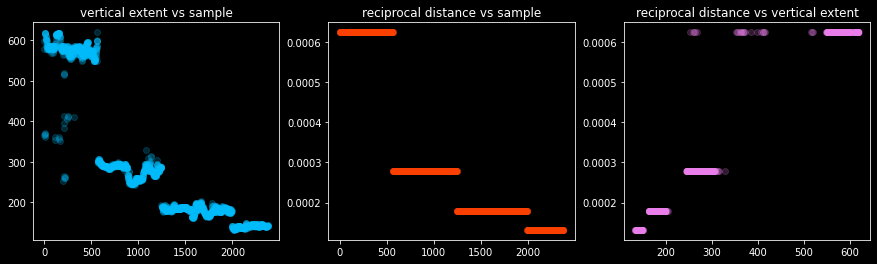

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('dark_background')

v_ext_calibration = np.apply_along_axis(vertical_extent, axis=0, arr=calibration_poses)
# note that the camera is 400mm in from the anchor point
CAMERA_ANCHOR_OFFSET = 400
distances = np.array([int(s[:-1]) for s in df.iloc[:, 75]]) * 1000 - CAMERA_ANCHOR_OFFSET

fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
ax[0].scatter(range(calibration_poses.shape[1]), v_ext_calibration, c='deepskyblue', alpha=0.2)
ax[0].set_title('vertical extent vs sample')
ax[1].scatter(range(calibration_poses.shape[1]), 1 / distances, c='orangered', alpha=0.2)
ax[1].set_title('reciprocal distance vs sample')
ax[2].scatter(v_ext_calibration, 1 / distances, c='violet', alpha=0.2)
ax[2].set_title('reciprocal distance vs vertical extent')
plt.show()

In [14]:
from sklearn.linear_model import LinearRegression

X = v_ext_calibration.reshape((-1, 1))
y = 1 / distances

DISTANCE_LR_PREDICTOR = LinearRegression(fit_intercept=False).fit(X, y)

In [15]:
def distance_lr(v_ext_px):
  return 1 / DISTANCE_LR_PREDICTOR.predict(v_ext_px)

distance_lr([[256]])[0]

3706.8341926971434

Compare the two pinhole factors derived from geometry and regression

In [16]:
GEOMETRY_FACTOR, 1 / DISTANCE_LR_PREDICTOR.coef_[0]

(960342.3680456491, 948949.5533304687)

# Visualise poses

In [17]:
IMG_WIDTH = 383
IMG_HEIGHT = 680
FIG_WIDTH = IMG_WIDTH / 100.0
FIG_HEIGHT = IMG_HEIGHT / 100.0

In [18]:
def plot_segments(ax, pose):
  seg_denom = len(B25_CONN) - 1.0
  for i, s in enumerate(B25_CONN.values()):
    a = s[0] * KS
    b = s[1] * KS
    if pose[a + KC] == 0 or pose[b + KC] == 0:
      continue
    xs = [a + KX, b + KX]
    ys = [a + KY, b + KY]
    ax.plot(pose[xs], IMG_HEIGHT - pose[ys], color=mpl.cm.hsv(i / seg_denom), lw=2)
  ax.set_xlim((0, IMG_WIDTH))
  ax.set_ylim((0, IMG_HEIGHT))  

# Infer distance

Load another set of pose data

In [19]:
keypoints_path = 'kpdata/post_2/octopus/' #@param
method_type = 'dir_multi' #@param ['file', 'dir', 'dir_multi']
slice_start = 2000 #@param
slice_end = 5700 #@param

build_method_name = 'build_keypoints_' + method_type
build_method = locals()[build_method_name]
keypoints = build_method(FS_ROOT + keypoints_path)
poses_all = np.array(single_person_poses(keypoints)).T
poses = poses_all[:,slice_start:slice_end]
poses.shape

(75, 3700)

In [20]:
# thanks again Jaime from stackoverflow
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [21]:
smoothing = 200 #@param

vertical_extents = np.apply_along_axis(vertical_extent, axis=0, arr=poses)
smoothed_vertical_extents = moving_average(vertical_extents, n=smoothing)

Visualise this pose data and inferred distance

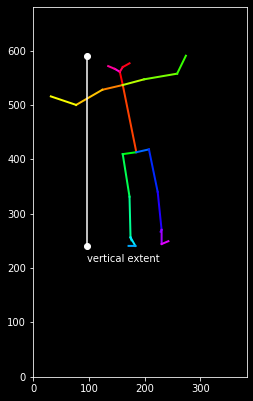

In [22]:
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
ax = fig.add_subplot()
pose_v_ext = poses[:, slice_end - slice_start - smoothing - 1]
plot_segments(ax, pose_v_ext)
ax.plot([IMG_WIDTH / 4, IMG_WIDTH / 4],
        [IMG_HEIGHT - valid_min(pose_v_ext), IMG_HEIGHT - valid_max(pose_v_ext)],
        '-o', color='white')
ax.text(IMG_WIDTH / 4, IMG_HEIGHT - valid_max(pose_v_ext) - 30, "vertical extent")
plt.show()

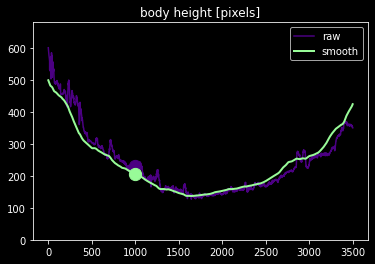

In [23]:
def plot_vertical_extents(ax, raw, smoothed, marker):
  sl = smoothed.shape[0]
  ax.plot(raw[:sl], color='indigo', zorder=1)
  ax.scatter(marker, raw[marker], s=150, color='indigo', zorder=1)
  ax.plot(smoothed, color='palegreen', lw=2, zorder=2)
  ax.scatter(marker, smoothed[marker], s=150, color='palegreen', zorder=2)
  ax.set_title('body height [pixels]')
  ax.legend(['raw', 'smooth'])
  ax.set_ylim((0, IMG_HEIGHT))
  #ax.set_yticks([])
  #ax.set_xticks([])

fig = plt.figure()
ax = fig.add_subplot()
plot_vertical_extents(ax, vertical_extents, smoothed_vertical_extents, 1000)
plt.show()

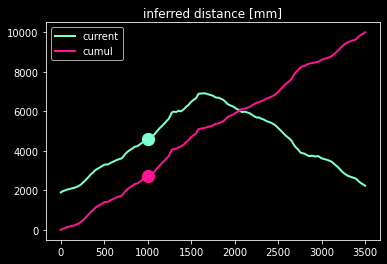

In [24]:
smoothed_distance = distance_lr(smoothed_vertical_extents.reshape((-1,1)))
cumulative_distance = np.cumsum(np.abs(np.diff(smoothed_distance)))

def plot_distances(ax, smoothed, cumulative, marker):
  ax.plot(smoothed, color='aquamarine', lw=2, zorder=1)
  ax.scatter(marker, smoothed[marker], s=150, color='aquamarine', zorder=1)
  ax.plot(cumulative, color='deeppink', lw=2, zorder=2)
  ax.scatter(marker, cumulative[marker], s=150, color='deeppink', zorder=2)
  ax.set_title('inferred distance [mm]')
  ax.legend(['current', 'cumul'])
  #ax.set_xticks([])
  #ax.set_yticks([])

fig = plt.figure()
ax = fig.add_subplot()
plot_distances(ax, smoothed_distance, cumulative_distance, 1000)
plt.show()

In [25]:
max(smoothed_distance)

6925.464274020007

# Odometer

Odometer visualisation code inlined from https://github.com/safetydave/maths-whimsy/blob/main/vis/odometer.ipynb

In [26]:
BASE = 10
DIGITS = np.roll(np.arange(BASE), 1)
WINDOW = 3

def display_window(target):
  return np.roll(DIGITS, -target)[:WINDOW]

def ease_quart(x):
  def ease_in(x):   return 8 * np.power(x, 4)
  def ease_out(x):  return 1 - np.power(-2 * x + 2, 4) / 2
  return np.piecewise(x, [x < 0.5, x >= 0.5], [ease_in, ease_out])

def ease_quad(x):
  def ease_in(x):   return 2 * np.power(x, 2)
  def ease_out(x):  return 1 - np.power(-2 * x + 2, 2) / 2
  return np.piecewise(x, [x < 0.5, x >= 0.5], [ease_in, ease_out])

def transfer(x, start=0.85):
  return np.piecewise(x,
                      [x < start, x >= start],
                      [0, lambda x: ease_quart((x - start) / (1 - start))])

In [27]:
OFFSET_FACTOR = 0.5

def odometer_values(x, max_wheel, min_wheel):
  offset = 0
  dws = np.zeros((max_wheel - min_wheel, WINDOW), dtype=int)
  offs = np.zeros(max_wheel - min_wheel)
  for i in range(min_wheel, max_wheel):
    # calculate nominal display digits and rotation offset
    place = pow(BASE, i)
    value = (x % place) / place
    rotation = value * BASE
    digit = int(rotation)
    adjust = OFFSET_FACTOR * offset
    remainder = (int(BASE * (rotation % 1)) + adjust) / BASE
    offset = remainder if i == min_wheel else transfer(remainder)
    # assign digits and offset
    dws[i - min_wheel,:] = display_window(digit)
    offs[i - min_wheel] = offset
  return dws, offs

In [28]:
import math

WHEELS = 6
BG_STEPS = 20
DIGIT_HEIGHT = 3 * BG_STEPS / 2
DIGIT_BASELINE = 3
DIGIT_SPACING = DIGIT_HEIGHT / 2
BG_SHADE_RANGE = 0.125
BG_Y = np.linspace(-1, 1, BG_STEPS, endpoint=True)
BG_V = np.cos(2 * math.pi * BG_SHADE_RANGE * BG_Y)
BG_M = np.stack([BG_V] * WHEELS).T
DIGIT_H_SHIFT = -1.2
LINE_H_SHIFT = 0.7

In [29]:
def plot_odometer(ax, values):
  ax.imshow(BG_M, origin='lower', aspect=(1.0 / BG_STEPS), cmap="Greys", vmin=0, vmax=1)
  ax.axis('off')
  dws = values[0]
  offs = values[1]
  for i in range(dws.shape[0]):
    hpos = dws.shape[0] + DIGIT_H_SHIFT - i
    vpos = DIGIT_BASELINE + DIGIT_SPACING * offs[i]
    ax.text(hpos, vpos + DIGIT_SPACING, dws[i, 0], fontsize=DIGIT_HEIGHT, clip_on=True)
    ax.text(hpos, vpos, dws[i, 1], fontsize=DIGIT_HEIGHT, clip_on=True)
    ax.text(hpos, vpos - DIGIT_SPACING, dws[i, 2], fontsize=DIGIT_HEIGHT, clip_on=True)
    if i > 0:
      lpos = hpos + LINE_H_SHIFT
      ax.plot([lpos, lpos], [0, BG_STEPS - 1], color='black')

In [30]:
def odometer(ax, x, max_wheel=(WHEELS + 1), min_wheel=1):
  return plot_odometer(ax, odometer_values(x, max_wheel, min_wheel))

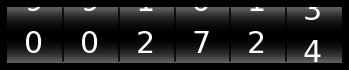

In [31]:
fig = plt.figure()
ax = fig.add_subplot()
odometer(ax, cumulative_distance[1000])
plt.show()

# Animated distance measure

Render a bunch of charts to animate into video

In [32]:
timesteps = slice_end - slice_start - smoothing
timesteps_test = 10

for i in range(timesteps_test):
  fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
  ax1 = fig.add_subplot(311)
  ax2 = fig.add_subplot(312)
  ax3 = fig.add_subplot(313)
  plot_vertical_extents(ax1, vertical_extents, smoothed_vertical_extents, i)
  plot_distances(ax2, smoothed_distance, cumulative_distance, i)
  odometer(ax3, cumulative_distance[i])
  ax3.set_title('slackometer [mm]')
  #plt.show()
  put_fig(f'dist_{i:04}', dir=(FS_ROOT + 'dist_fig/'))
  plt.close()